Imports

In [134]:
import joblib
import numpy as np
import pandas as pd
from config import *
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import learning_curve
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.ensemble import RandomForestRegressor, VotingRegressor, AdaBoostRegressor
from sklearn.tree import DecisionTreeRegressor

Preparacion del conjunto de datos

In [144]:
data = pd.read_csv(formated_train)

# convertir fecha a datetime y luego a int
data['fechaUltimaActualizacion'] = pd.to_datetime(data['fechaUltimaActualizacion'])
data['fechaUltimaActualizacion'] = data['fechaUltimaActualizacion'].astype('int64')

features = ['terrenoEdificado', 'coordX', 'coordY', 'barrio', 'fechaUltimaActualizacion']
data_for_clustering = data[features]

scaler_kmeans = StandardScaler()
scaled_data = scaler_kmeans.fit_transform(data_for_clustering)

kmeans = joblib.load(kmeans_model)
data['clusterKM'] = kmeans.predict(scaled_data)

Modelo ensamblado inicial

In [145]:
ensamble = joblib.load(ensamble_precio_model)

features = ['terrenoEdificado', 'comisariaCercana', 'transporteCercano', 
            'saludCercana', 'coordX', 'coordY', 'clusterKM', 'barrio', 'fechaUltimaActualizacion']
data_for_train = data[features]
target_column = 'precioUSD'
target = data[target_column]

scaler_ensamble = StandardScaler()
scaled_data = scaler_ensamble.fit_transform(data_for_train)

X_train, X_test, y_train, y_test = train_test_split(data_for_train, target, train_size=0.99, random_state=33)

X_test_scaled = scaler_ensamble.transform(X_test)
all_data_predictions = ensamble.predict(X_test_scaled)

ensemble_r2 = r2_score(y_test, all_data_predictions)
ensemble_rmse = np.sqrt(mean_squared_error(y_test, all_data_predictions))

print(f'Ensamble R2: {ensemble_r2}')
print(f'Ensamble RMSE: {ensemble_rmse}')

Ensamble R2: 0.8562784673097436
Ensamble RMSE: 31030.90300354034


Confección del modelo de correccion

In [146]:
residuals = y_test - all_data_predictions

residual_boosting_model = AdaBoostRegressor(base_estimator=DecisionTreeRegressor(max_depth=5, criterion='absolute_error'), n_estimators=50, random_state=42)
residual_boosting_model.fit(X_test, residuals)

residual_pred_ada = residual_boosting_model.predict(X_test)
final_predictions = all_data_predictions + residual_pred_ada

r2 = r2_score(y_test, final_predictions)
rmse = np.sqrt(mean_squared_error(y_test, final_predictions))

print(f"R^2 para el modelo ensamblado corregido con residuos de boosting: {r2}")
print(f"RMSE del modelo ensamblado corregido con residuos de boosting: {rmse}")

R^2 para el modelo ensamblado corregido con residuos de boosting: 0.9947848986886786
RMSE del modelo ensamblado corregido con residuos de boosting: 5911.0532078749775


c:\Users\benja\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Predicciones

In [147]:
# Choose random sample of 100 data points
random_sample = np.random.choice(data.index, size=100, replace=False)

In [230]:
# Predecir el precio de 100 casas con fecha de actualizacion 2023-01-01
samples = data.iloc[random_sample].copy()
samples.loc[:, "fechaReal"] = samples.loc[:, "fechaUltimaActualizacion"].copy()
samples.loc[:, "fechaUltimaActualizacion"] = pd.to_datetime("2023-12-15", format="%Y-%m-%d").to_numpy().astype("int64")
samples.drop(columns=["clusterKM"], inplace=True)

features = ['terrenoEdificado', 'coordX', 'coordY', 'barrio', 'fechaUltimaActualizacion']
data_for_clustering = samples[features]
scaled_data = scaler_kmeans.fit_transform(data_for_clustering)

samples['clusterKM'] = kmeans.predict(scaled_data)

In [231]:
features = ['terrenoEdificado', 'comisariaCercana', 'transporteCercano', 
            'saludCercana', 'coordX', 'coordY', 'clusterKM', 'barrio', 'fechaUltimaActualizacion']
samples_features = samples[features]
scaled_data = scaler_ensamble.fit_transform(samples_features)

predictions = ensamble.predict(scaled_data)
residuals = residual_boosting_model.predict(samples_features)

final_predictions = predictions + residuals

samples["prediccion_15-12"] = predictions
samples["prediccion_corregida_15-12"] = final_predictions

In [232]:
samples.drop(columns=["clusterKM", "geometry", 'valComisaria', 'valTransporte', 'valSalud','valoracionServicios', 'pm2', 'cantDormitorios', 'cantBanos', 'cantCochera', 'terrenoTotal', 'tipoPropiedad', 'fechaUltimaActualizacion'], inplace=True)

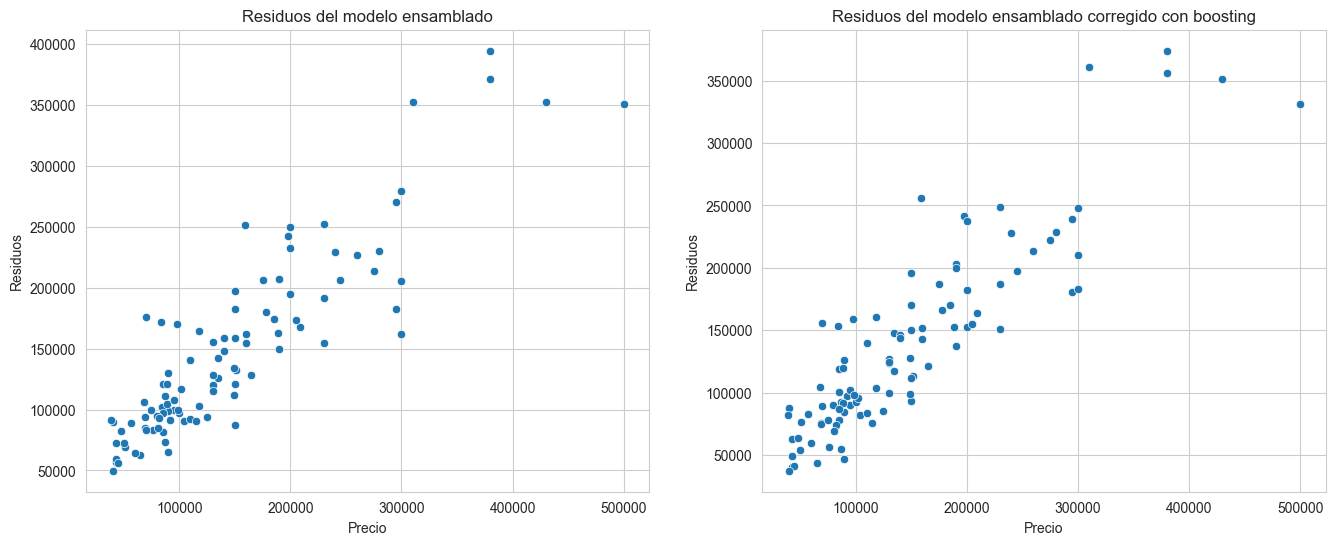

In [225]:
# Plot residuals
fig, ax = plt.subplots(1, 2, figsize=(16, 6))
sns.scatterplot(x=samples["precioUSD"], y=samples["prediccion_1-12"], ax=ax[0])
sns.scatterplot(x=samples["precioUSD"], y=samples["prediccion_corregida_1-12"], ax=ax[1])
ax[0].set_title("Residuos del modelo ensamblado")
ax[1].set_title("Residuos del modelo ensamblado corregido con boosting")
ax[0].set_ylabel("Residuos")
ax[1].set_ylabel("Residuos")
ax[0].set_xlabel("Precio")
ax[1].set_xlabel("Precio")
plt.show()
